In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image

# pytorch building the CNN
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn


#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


In [ ]:


# Define transforms including normalization
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define train and test directories


train_dir = '/content/drive/MyDrive/Cropped_Final/Train'
test_dir = '/content/drive/MyDrive/Cropped_Final/Test'

# Load train and test data
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the SqueezeNet model
squeezenet = models.squeezenet1_0(pretrained=True)

# Load the SqueezeNet model with specified weights
#squeezenet = models.squeezenet1_0(pretrained=True, init_weights=False)

num_classes = len(train_loader.dataset.classes)
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

# Set the model to training mode
squeezenet.train()

# Set the learning rate
learning_rate = 0.001

# Define an optimizer with the specified learning rate
optimizer = optim.SGD(squeezenet.parameters(), lr=learning_rate, momentum=0.9)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Early stopping
best_loss = float('inf')
patience = 3  # Number of epochs without improvement before stopping
no_improvement = 0

# Number of epochs
num_epochs = 20  # You can adjust this as needed

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        predictions = squeezenet(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping!")
            break

print("Training complete.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 63.9MB/s]


Epoch [1/20] - Loss: 0.7139
Epoch [2/20] - Loss: 0.6175
Epoch [3/20] - Loss: 0.4820
Epoch [4/20] - Loss: 0.3072
Epoch [5/20] - Loss: 0.2130
Epoch [6/20] - Loss: 0.1821
Epoch [7/20] - Loss: 0.0722
Epoch [8/20] - Loss: 0.0368
Epoch [9/20] - Loss: 0.0134
Epoch [10/20] - Loss: 0.0054
Epoch [11/20] - Loss: 0.0629
Epoch [12/20] - Loss: 0.0788
Epoch [13/20] - Loss: 0.0111
Early stopping!
Training complete.


In [ ]:
# Evaluation
correct = 0
total = 0

predicted_labels = []
true_labels = []

# Set the model to evaluation mode
squeezenet.eval()

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        predictions = squeezenet(images)
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2%}")


Test Accuracy: 76.67%


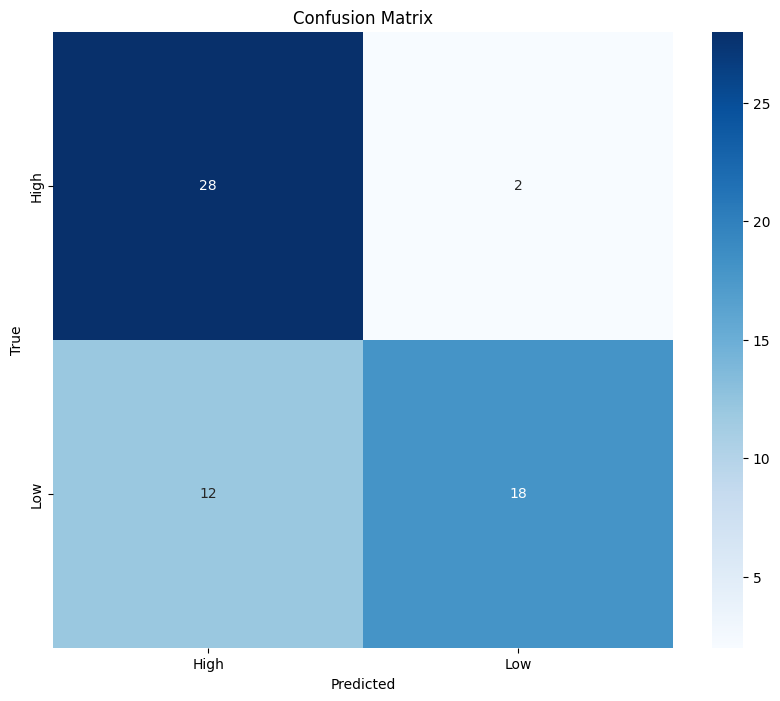

In [ ]:

# Evaluation
predicted_labels = []
true_labels = []

# Set the model to evaluation mode
squeezenet.eval()

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        predictions = squeezenet(images)
        _, predicted = torch.max(predictions.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as heatmap
class_names = test_loader.dataset.classes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8000
Recall: 0.7667
F1 Score: 0.7600


In [ ]:
print("Shape of true_labels:", true_labels.shape)
print("Shape of predicted_scores:", predicted_scores.shape)

Shape of true_labels: (60, 1)
Shape of predicted_scores: (60, 2)


In [ ]:
true_labels = true_labels.reshape(-1)
predicted_scores = predicted_scores[:, 1]  # Select the scores for the positive class

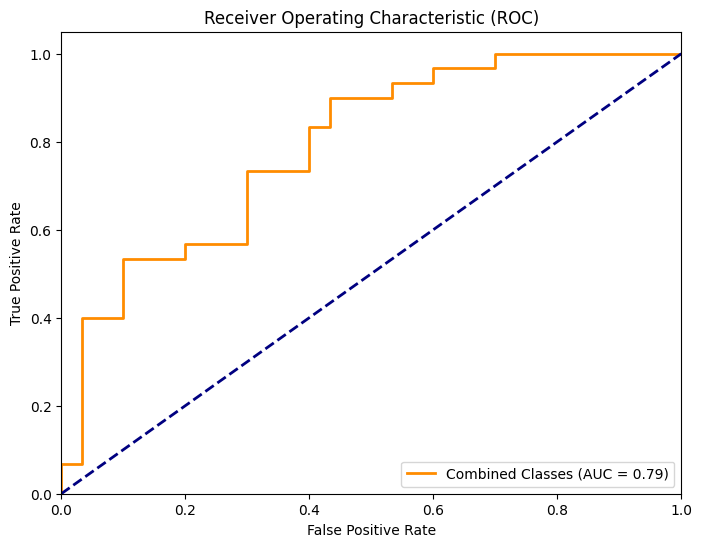

In [ ]:

# Reshape true_labels
true_labels = true_labels.reshape(-1)

# Initialize variables to store ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_scores)
        roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError:
        pass

# Compute ROC curve and ROC area for combined classes
fpr_combined, tpr_combined, _ = roc_curve(true_labels, predicted_scores)
roc_auc_combined = auc(fpr_combined, tpr_combined)

# Plot the ROC curve for combined classes
plt.figure(figsize=(8, 6))
plt.plot(fpr_combined, tpr_combined, color='darkorange', lw=2, label=f'Combined Classes (AUC = {roc_auc_combined:.2f})')

# Plot the ROC curve for a random classifier (no skill)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Show the plot
plt.show()


